In [1]:
#To get detailed description if get CUDA error
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
import os
os.chdir('../')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import gdown
import time

Global seed set to 0
/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/pytorch_lightning/utilities/warnings.py:54: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  "pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6"
/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [4]:
st = time.time()

In [5]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [6]:
# url = 'https://drive.google.com/uc?id=1Vh6RpYkusbGIZQC8GMFe3OKVDk5PWEpC'
# output = 'pbmc.h5ad'
# gdown.download(url, output, quiet=False)

In [7]:
adata = sc.read('pbmc.h5ad')
# adata = sc.pp.subsample(adata, fraction=None, n_obs=5000, random_state=0, copy=True)

In [8]:
adata.X = adata.layers["counts"].copy()

In [9]:
condition_key = 'batch'
target_conditions = ['10X']

trvae_epochs = 500
surgery_epochs = 500

early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

In [10]:
removed_viallni = ['Villani']
adata_villani_removed = adata[~adata.obs.study.isin(removed_viallni)].copy()
# source_adata = adata_villani_removed[adata_villani_removed.obs['study'].isin(['Freytag'])].copy()
# target_adata = adata[adata.obs.study.isin(target_conditions)].copy()
conditions = adata_villani_removed.obs['batch'].unique().tolist()
print(adata_villani_removed.obs['batch'])
adata_villani_removed, conditions

index
AAACCTGCAGCGAACA-1-Oetjen_A                Oetjen_A
AAACCTGCATGTCCTC-1-Oetjen_A                Oetjen_A
AAACCTGGTCGACTGC-1-Oetjen_A                Oetjen_A
AAACCTGGTCGCTTCT-1-Oetjen_A                Oetjen_A
AAACCTGTCCCGACTT-1-Oetjen_A                Oetjen_A
                                          ...      
TTTGTCAAGCTCCTTC-1-Sun_sample4_TC    Sun_sample4_TC
TTTGTCAAGCTGAAAT-1-Sun_sample4_TC    Sun_sample4_TC
TTTGTCATCATCATTC-1-Sun_sample4_TC    Sun_sample4_TC
TTTGTCATCTCGCTTG-1-Sun_sample4_TC    Sun_sample4_TC
TTTGTCATCTGTCTCG-1-Sun_sample4_TC    Sun_sample4_TC
Name: batch, Length: 32484, dtype: category
Categories (9, object): ['10X', 'Freytag', 'Oetjen_A', 'Oetjen_P', ..., 'Sun_sample1_CS', 'Sun_sample2_KC', 'Sun_sample3_TB', 'Sun_sample4_TC']


(AnnData object with n_obs × n_vars = 32484 × 12303
     obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
     layers: 'counts',
 ['Oetjen_A',
  'Oetjen_P',
  'Oetjen_U',
  'Freytag',
  '10X',
  'Sun_sample1_CS',
  'Sun_sample2_KC',
  'Sun_sample3_TB',
  'Sun_sample4_TC'])

In [11]:
trvae = sca.models.TRVAE(
    adata=adata_villani_removed,
    condition_key=condition_key,
    conditions=conditions,
    hidden_layer_sizes=[128, 128],
 )


INITIALIZING NEW NETWORK..............
	Input Layer in, out and cond: 12303 128 9
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 9
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 12303 



In [12]:
trvae.train(
    n_epochs=trvae_epochs,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs
)

 |█-------------------| 7.0%  - val_loss: 4345.8733943059 - val_recon_loss: 4294.2103553185 - val_kl_loss: 40.8246515714 - val_mmd_loss: 44.7228166140
ADJUSTED LR
 |██------------------| 11.2%  - val_loss: 4336.8288480319 - val_recon_loss: 4285.4430401142 - val_kl_loss: 40.9745499538 - val_mmd_loss: 40.1178594002
ADJUSTED LR
 |██------------------| 14.0%  - val_loss: 4345.5033522386 - val_recon_loss: 4291.2792311448 - val_kl_loss: 40.9772065970 - val_mmd_loss: 40.0870163257
ADJUSTED LR
 |███-----------------| 17.0%  - val_loss: 4356.9675386869 - val_recon_loss: 4300.4352276142 - val_kl_loss: 40.9768989270 - val_mmd_loss: 39.3220386505
ADJUSTED LR
 |███-----------------| 18.4%  - val_loss: 4359.4831167368 - val_recon_loss: 4300.5232403095 - val_kl_loss: 40.9769228422 - val_mmd_loss: 40.3154218380
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best s

In [13]:
adata_villani_removed_latent = sc.AnnData(trvae.get_latent())
adata_villani_removed_latent.obs['cell_type'] = adata_villani_removed.obs["final_annotation"].tolist()
adata_villani_removed_latent.obs['batch'] = adata_villani_removed.obs["batch"].tolist()

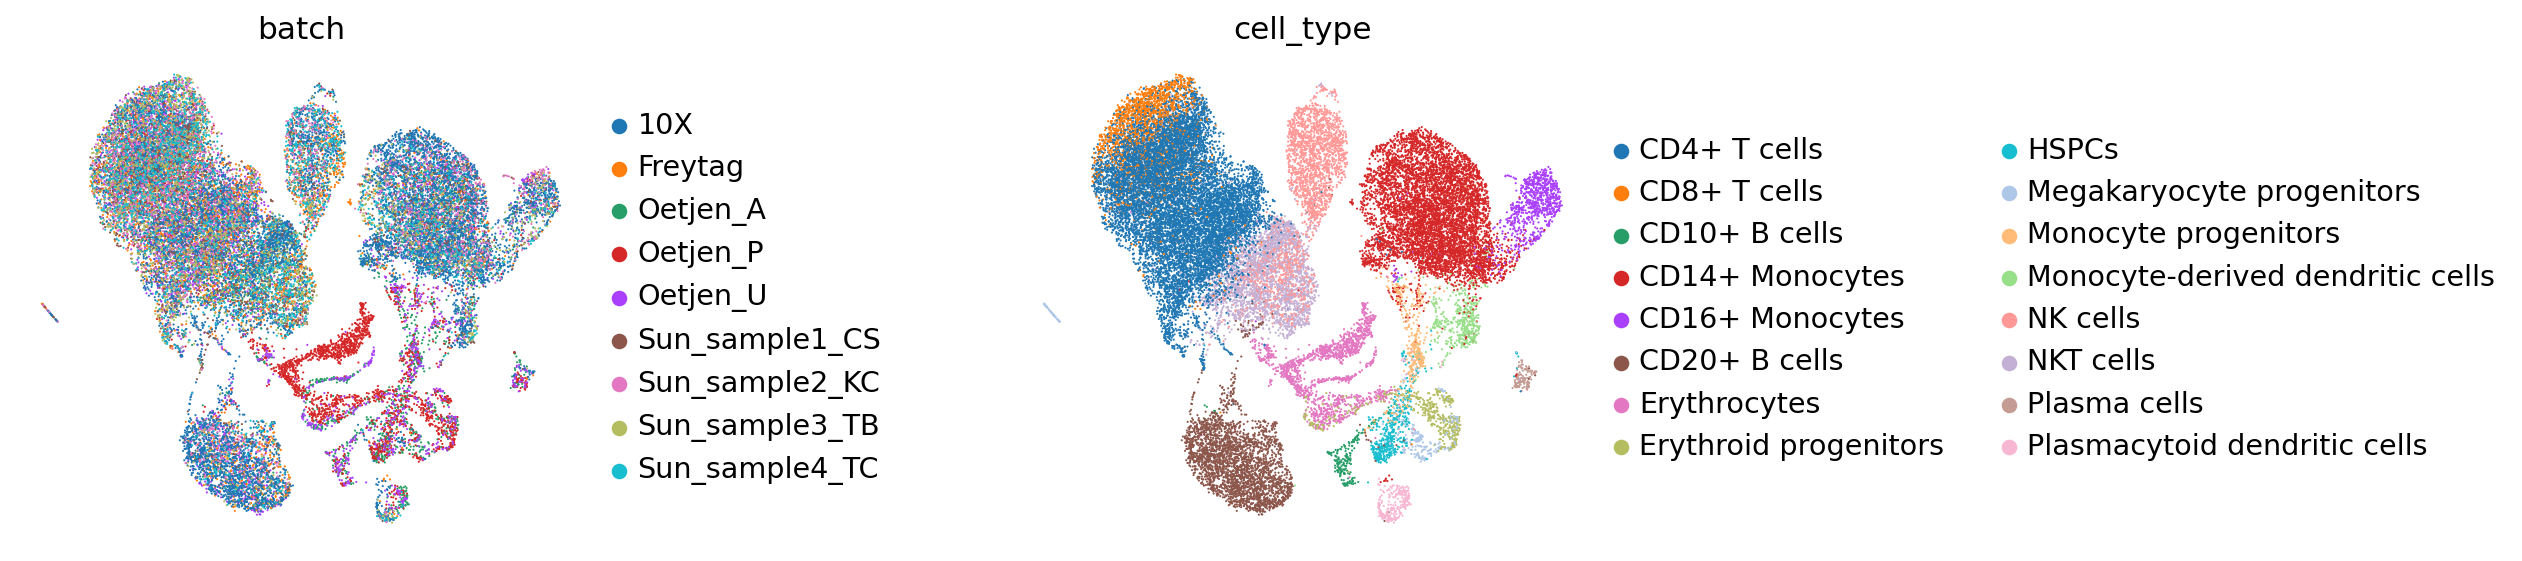

In [14]:
sc.pp.neighbors(adata_villani_removed_latent, n_neighbors=8)
sc.tl.leiden(adata_villani_removed_latent)
sc.tl.umap(adata_villani_removed_latent)
sc.pl.umap(adata_villani_removed_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

In [15]:
ref_path = 'reference_model_PBMC/'
trvae.save(ref_path, overwrite=True)

In [16]:
elapsed_time = time.time() - st
print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Execution time: 01:30:48


In [17]:
import scanpy
import scib
arches_nb_graph=sc.pp.neighbors(adata_villani_removed_latent, n_neighbors=8, n_pcs=None, use_rep='X')
Batch_corr_graph_conn_std=scib.metrics.graph_connectivity(adata_villani_removed_latent, 'batch')

Batch_corr_graph_conn_std

0.3603788592508095

In [19]:
sc.tl.umap(adata_villani_removed_latent)
Batch_corr_ASW_std=scib.metrics.silhouette_batch(adata_villani_removed_latent, batch_key='batch', group_key='cell_type', embed='X_umap')
Batch_corr_ASW_std


mean silhouette per group:                                   silhouette_score
group                                             
CD10+ B cells                             0.893232
CD14+ Monocytes                           0.882792
CD16+ Monocytes                           0.708158
CD20+ B cells                             0.731060
CD4+ T cells                              0.746523
CD8+ T cells                              0.784832
Erythrocytes                              0.829387
Erythroid progenitors                     0.830982
HSPCs                                     0.649603
Megakaryocyte progenitors                 0.780700
Monocyte progenitors                      0.783019
Monocyte-derived dendritic cells          0.721752
NK cells                                  0.724718
NKT cells                                 0.786975
Plasma cells                              0.648370
Plasmacytoid dendritic cells              0.640251


0.7588972230375477

In [20]:
Bio_cons_ASW_std=scib.metrics.silhouette(adata_villani_removed_latent, group_key='cell_type', embed='X_umap')
Bio_cons_ASW_std

0.5903133973479271

In [21]:
isolated_labels_std=scib.metrics.isolated_labels(adata_villani_removed_latent, label_key='cell_type', batch_key='batch', embed='X_umap')
isolated_labels_std

isolated labels: no more than 3 batches per label


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


CD10+ B cells: 0.873994638069705


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Erythrocytes: 0.8439173680183626


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Erythroid progenitors: 0.75


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Monocyte progenitors: 0.7508854781582055


0.8046993710615682